# Vocabulary size에 따른 뉴스 카테고리 다중분류 모델 성능 평가하기 
- vocabulary size에 따른 모델 성능 평가
    1. vocabulary size 정하기
    2. 데이터 불러오기
    3. 모델 훈련
    4. 모델 평가
- 평가해볼 vocabulary size 정하기
    - 문제에서 정해진 크기
        - None, 5000
    - 전체에서 <unk> 처리되는 비율에 따라 나누기 

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import reuters
import tensorflow_addons as tfa

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기 

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
vocabulary = reuters.get_word_index()

## 단어 빈도 조사하기

In [3]:
# 단어 확인해보기
index_word = {(index + 3): word for word, index in vocabulary.items()}
index_word.update({
    0: '<pad>',
    1: '<sos>',
    2: '<unk>',
})

def show_voca(start, end):
    for i in range(start, end):
        if i == 3:
            continue
        print(i, index_word[i])

show_voca(0, 24)

0 <pad>
1 <sos>
2 <unk>
4 the
5 of
6 to
7 in
8 said
9 and
10 a
11 mln
12 3
13 for
14 vs
15 dlrs
16 it
17 reuter
18 000
19 1
20 pct
21 on
22 from
23 is


In [4]:
# 모든 문서를 한 리스트로 통합하기
word_list = np.sum(x_train)
print(len(word_list))

1307239


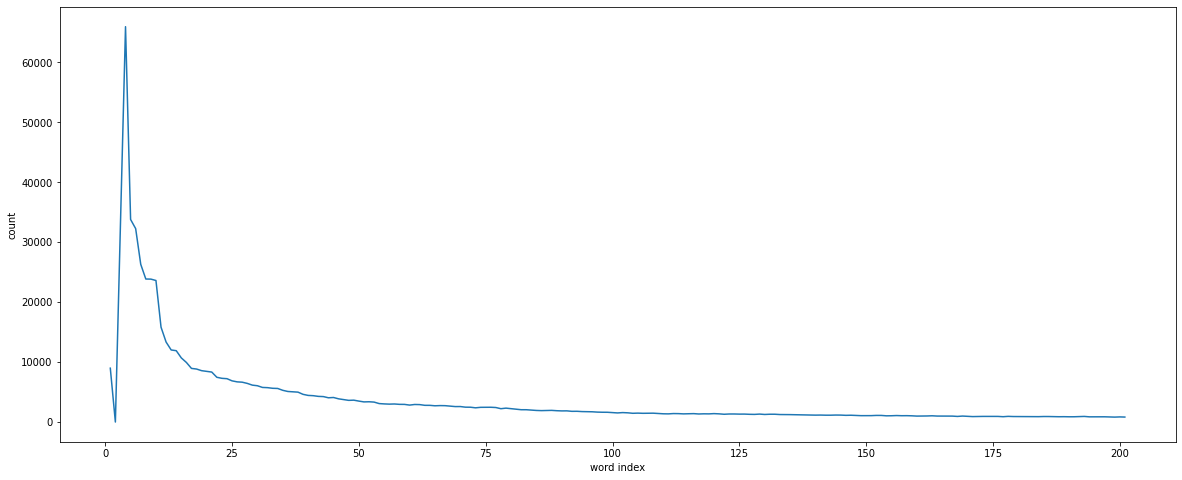

In [5]:
# 훈련 데이터셋의 단어 빈도 확인하기
frequencies = np.unique(word_list, return_counts=True)

_, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('word index')
ax.set_ylabel('count')
ax.plot(frequencies[0][:200], frequencies[1][:200]) # 200 이후로는 빈도가 급격히 낮아짐
plt.show()

In [6]:
# 백분위수를 통해 소실되지 않는 토큰 비율에 따른 vocabulary size 확인하기
for p in [0, 25, 50, 75, 100]:
    print(f'{p}%:\t{np.percentile(word_list, p)}')

0%:	1.0
25%:	18.0
50%:	119.0
75%:	773.0
100%:	30981.0


In [7]:
# 75% 이후 급격하게 vocabulary 수가 늘어나 90%~100% 사이로 다시 확인해보기
for p in [90, 92.5, 95, 97.5, 100]:
    print(f'{p}%:\t{np.percentile(word_list, p)}') # 특수 토큰 포함

90%:	3166.0
92.5%:	4393.0
95%:	6380.0
97.5%:	10618.0
100%:	30981.0


In [8]:
# 실제 누적 분포 확인하기
def get_word_cumulative_frequency(num_words):
    return np.mean(np.array(list(map(lambda x: int(x <= num_words), word_list))))

for num_words in [119, 773, 3166, 5000, 6380, 10618]:
    print(f'{num_words}\t{get_word_cumulative_frequency(num_words):.3f}')

119	0.500
773	0.750
3166	0.900
5000	0.934
6380	0.950
10618	0.975


## 테스트할 vocabulary size
- 119: 50%
- 773: 75%
    - 단어수가 극단적으로 작은 경우 모델이 잘 판단할 수 있는지 확인해보기
- 3166: 90%
- 5000: 93.4%
- 6380: 95%
- 106218: 97.5%
- 30982(None): 100%

## 백분위수에 해당하는 단어 확인하기
- 예상
    - 인덱스 번호가 커질수록 고유명사가 많이 등장할 것
- 확인 결과
    - 백분위수를 중심으로 10개 단어 확인
    - 50%를 제외하면 별 차이는 없어보임
    - 75% 이후로는 고유명사 빈도가 비슷한 것으로 보임

In [9]:
#voc_sizes = [119, 776, 3169, 5000, 6383, 10621, None]
# 시간상 모두 돌려볼 수 없어서 3가지만 사용
voc_sizes = [776, 5000, None]

In [10]:
# 백분위수 50%에 해당하는 단어들
show_voca(114, 124)

114 could
115 we
116 offer
117 over
118 told
119 20
120 agreement
121 week
122 production
123 note


In [11]:
# 백분위수 75%에 해당하는 단어들
show_voca(771, 781)

771 tokyo
772 scheduled
773 respectively
774 impact
775 turnover
776 local
777 included
778 france
779 leading
780 mine


In [12]:
# 백분위수 90%에 해당하는 단어들
show_voca(3164, 3174)

3164 seemed
3165 venezuelan
3166 compensate
3167 zambia
3168 brand
3169 cominco
3170 multi
3171 alan
3172 pty
3173 georgia


In [13]:
# 백분위수 93.4%에 해당하는 단어들
show_voca(4995, 5005)

4995 seaway
4996 restructured
4997 night's
4998 unknown
4999 731
5000 carries
5001 promise
5002 distillers
5003 reversal
5004 preserve


In [14]:
# 백분위수 95%에 해당하는 단어들
show_voca(6378, 6388)

6378 salaries
6379 consisting
6380 pooling
6381 word
6382 378
6383 widen
6384 539
6385 considerations
6386 worry
6387 579


In [15]:
# 백분위수 97.5%에 해당하는 단어들
show_voca(10616, 10626)

10616 alexander
10617 complied
10618 lacking
10619 conditionally
10620 providence
10621 cochran
10622 shortfalls
10623 motors'
10624 entwistle
10625 lorries


In [16]:
# 백분위수 100%에 해당하는 단어들
show_voca(30973, 30983)

30973 clampdown
30974 corporacion
30975 staalfabrieken
30976 odilon
30977 guard's
30978 recirculation
30979 capco
30980 figueras
30981 jung
30982 northerly


## 모델 훈련 및 평가 루프
1. 문서 벡터화
2. 모델 생성
3. 훈련 데이터셋을 통해 훈련
4. 테스트 데이터셋을 통해 평가

In [66]:
# 정수 시퀀스를 텍스트로 디코딩
def decode_sequence(seq):
    return ' '.join([index_word[i] for i in seq])

# tf-idf로 문서 벡터화
def vectorize_ducuments(x_train, x_test):
    x_train = map(decode_sequence, x_train)
    x_test = map(decode_sequence, x_test)
    
    vectorizer = TfidfVectorizer()
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    return x_train, x_test

# 주어진 vocabulary size로 모델 학습 후 평가
def train_and_evaluate(num_words):
    # 정해진 크기만큼 어휘 사전 생성
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    x_train, x_test = vectorize_ducuments(x_train, x_test)
    
    models = [
        MultinomialNB(), ComplementNB(),
        DecisionTreeClassifier(max_depth=10), 
        RandomForestClassifier(n_estimators=5, max_depth=10, n_jobs=8),
        LogisticRegression(C=10000, penalty='l2', max_iter=3000, n_jobs=8), 
        LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
        GradientBoostingClassifier(),
    ]
    
    # VotingClassifier 추가
    estimators = [('lr', LogisticRegression(C=10000, penalty='l2', max_iter=3000)), 
                  ('rf', RandomForestClassifier(n_estimators=5, max_depth=10)), 
                  ('gnb', GradientBoostingClassifier()),
                 ]
    models.append(VotingClassifier(estimators=estimators, voting='soft', n_jobs=8))
    
    # 정확도와 f1 score를 모델마다 저장
    accuracies = {}
    f1_scores = {}
    for model in tqdm(models):
        # 학습
        model.fit(x_train, y_train)
        # 평가
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = np.zeros((46,))
        for i in range(46):
            f1[i] = f1_score(y_test, y_pred, average='micro')
        accuracies.update({model.__class__.__name__: accuracy})
        f1_scores.update({model.__class__.__name__: f1})
        
    return accuracies, f1_scores

In [ ]:
acc_by_voc_size = []
f1_by_voc_size = []

# 각 vocabulary size마다 반복
for num_words in voc_sizes:
    acc, f1 = train_and_evaluate(num_words)
    acc_by_voc_size.append(acc)
    f1_by_voc_size.append(f1)

 50%|█████     | 4/8 [00:01<00:01,  2.58it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 62%|██████▎   | 5/8 [02:40<02:22, 47.42s/it]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 88%|████████▊ | 7/8 [16:46<04:20, 260.25s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

In [ ]:
acc_df = pd.DataFrame(acc_by_voc_size, index=map(str, voc_sizes))
acc_df

In [ ]:
# 정확도 비교
_, ax = plt.subplots(figsize=(12, 6))
acc_df.plot.bar(ax=ax)
ax.set_ylim((0.55, 0.9))
plt.legend(loc=8)
plt.show()

In [ ]:
# fi-score 비교
for i in range(3):
    print(voc_sizes[i], "size")
    f1_df = pd.DataFrame(f1_by_voc_size[i])
    print(f1_df)
    print()

## 딥러닝 모델과 비교하기

In [27]:
inputs = keras.Input(shape=(None,))
embedding = layers.Embedding(5000, 32)(inputs)
x = layers.SimpleRNN(32)(embedding)
outputs = layers.Dense(46, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [28]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

437.16811776094886


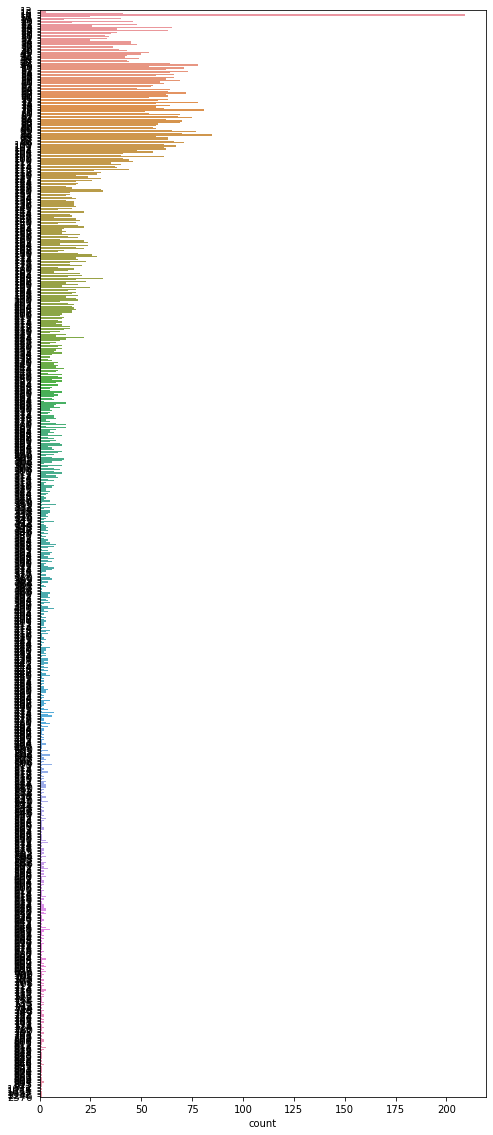

In [29]:
_, ax = plt.subplots(figsize=(8, 20))
length_seq = list(map(len, x_train))
print(np.mean(length_seq) + 2 * np.std(length_seq))
sns.countplot(y=length_seq, ax=ax)
plt.show()

In [30]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=437)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=437)

In [31]:
model.fit(x_train, y_train,
          epochs=50,
          batch_size=512)

Epoch 1/50
18/18 [==============================] - 7s 344ms/step - loss: 3.6637 - accuracy: 0.1631
Epoch 2/50
18/18 [==============================] - 6s 335ms/step - loss: 3.1588 - accuracy: 0.3515
Epoch 3/50
18/18 [==============================] - 6s 335ms/step - loss: 2.6853 - accuracy: 0.3635
Epoch 4/50
18/18 [==============================] - 6s 336ms/step - loss: 2.4233 - accuracy: 0.3534
Epoch 5/50
18/18 [==============================] - 6s 336ms/step - loss: 2.3043 - accuracy: 0.4008
Epoch 6/50
18/18 [==============================] - 6s 337ms/step - loss: 2.1902 - accuracy: 0.4627
Epoch 7/50
18/18 [==============================] - 6s 333ms/step - loss: 2.0751 - accuracy: 0.4953
Epoch 8/50
18/18 [==============================] - 6s 333ms/step - loss: 1.9930 - accuracy: 0.5081
Epoch 9/50
18/18 [==============================] - 6s 334ms/step - loss: 1.9023 - accuracy: 0.5218
Epoch 10/50
18/18 [==============================] - 6s 333ms/step - loss: 1.8268 - accuracy: 0.5298

In [37]:
y_pred = model.predict(x_test)
acc_test = accuracy_score(y_test, tf.argmax(y_pred, axis=-1))
print(f'정확도: {acc_test:.4f}')

정확도: 0.4969


In [55]:
print('f1 score')
for i in range(46):
    f1_test = f1_score(y_test, tf.argmax(y_pred, axis=1), labels=[i], average='micro')
    print(f'class {i}: {f1_test:.4f}')

f1 score
class 0: 0.1176
class 1: 0.2140
class 2: 0.0000
class 3: 0.7947
class 4: 0.5998
class 5: 0.0000
class 6: 0.3200
class 7: 0.0000
class 8: 0.1667
class 9: 0.0851
class 10: 0.0870
class 11: 0.1951
class 12: 0.1000
class 13: 0.0698
class 14: 0.0000
class 15: 0.0000
class 16: 0.1297
class 17: 0.0000
class 18: 0.0000
class 19: 0.3433
class 20: 0.1983
class 21: 0.1455
class 22: 0.0000
class 23: 0.0000
class 24: 0.0488
class 25: 0.2083
class 26: 0.0000
class 27: 0.0000
class 28: 0.0000
class 29: 0.0000
class 30: 0.0952
class 31: 0.0000
class 32: 0.1176
class 33: 0.0000
class 34: 0.0000
class 35: 0.0000
class 36: 0.0000
class 37: 0.0000
class 38: 0.0000
class 39: 0.0000
class 40: 0.2667
class 41: 0.0000
class 42: 0.0000
class 43: 0.1667
class 44: 0.7500
class 45: 0.0000


# 결론
- 모델 성능
    - 나이브 베이즈 모델과 SVC
        - 5000 이후로는 모델 성능이 향상되지 않음
    - 랜덤 포레스트
        - 776 이후로 모델 성능이 오히려 떨어짐
- vocabulary size에 따른 모델 성능
    - 일정 수준 이상 올라가면 성능이 향상되지 않음
        - 심지어 성능이 하락하는 현상도 발생함